#### Solving the Incompressible Navier-Stokes Equation with Obstacle using FEniCS

In this notebook, we solve the incompressible Navier-Stokes equation in a channel with a square obstacle using two different approaches. The first approach utilizes a reference mesh, while the second approach employs a Cartesian mesh with a penalized term in the equations to model the obstacle.

#### References

1. Hans Petter Langtangen, Anders Logg, "Solving PDEs in Python – The FEniCS Tutorial Volume" (2017).
2. Philippe Angot, Bruneau, "A Penalization Method to Take into Account Obstacles in Incompressible Viscous Flows" (1999).
3. Katuhiko Goda, "A Multistep Technique with Implicit Difference Schemes for Calculating Two- or Three-Dimensional Cavity Flows" (1978).

We utilize the first reference to understand the mathematical theorems and convergence proofs. The second reference provides insights into the FEniCS library, while the third reference explains the variation formulation for the Incompressible Navier-Stokes equation using Chorin's scheme for time discretization.

<br>
Begin importing necessary libraries

In [28]:
from dolfin import *
import dolfin
import numpy as np
import matplotlib.pyplot as plt

In [29]:
# Print log messages only from the root process in parallel
dolfin.parameters["std_out_all_processes"] = False;

<br>
We are going to define the mesh of the exact solution that we are going to call mesh_ref because it woulb be the reference mesh for our solution. This mesh was generated in Gmsh using triangular elements.


Plotting a ReferenceMesh
23178


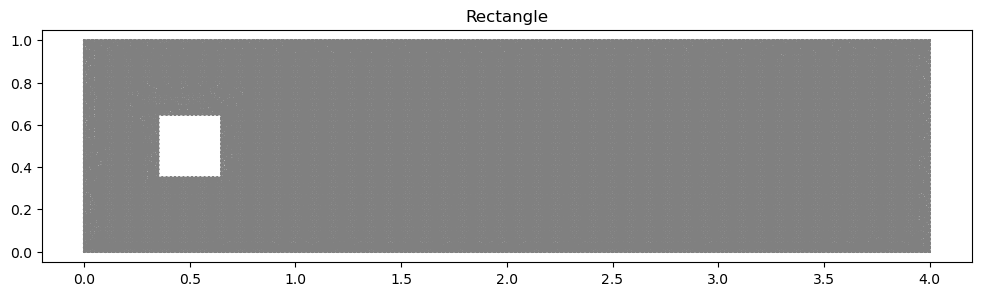

In [117]:
# Define the reference mesh 
mesh_ref = Mesh('mesh/mesh-square.xml')
print("Plotting a ReferenceMesh")

# Print number of elements an plot
print(mesh_ref.num_cells())
fig_ref, ax_ref = plt.subplots(figsize=(12, 4))
dolfin.plot(mesh_ref, title="Rectangle", axes = ax_ref)

<br>
Now we define a rectangular mesh with triangular elements. This mesh will be used as a domain for the Brinkman problem. 

Plotting a RectangleMesh
23328


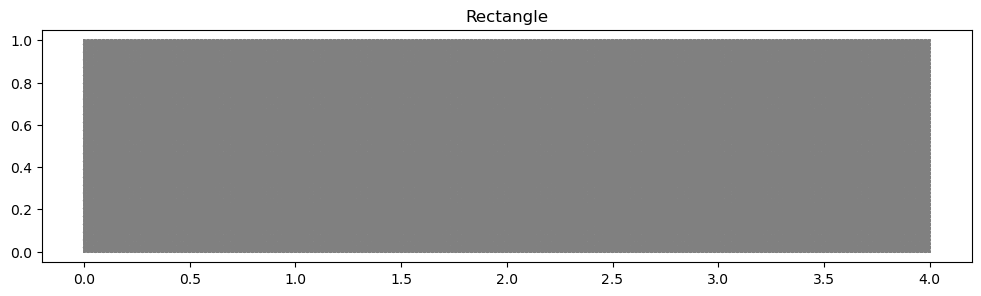

In [118]:
# Create mesh and define function space
mesh_penal = dolfin.RectangleMesh(dolfin.Point(0.0, 0.0), dolfin.Point(4.0, 1.0), 216, 54, "right/left")
print("Plotting a RectangleMesh")

# Print number of elements an plot
print(mesh_penal.num_cells())
fig_penal, ax_penal = plt.subplots(figsize=(12, 4))
dolfin.plot(mesh_penal, title="Rectangle", axes = ax_penal)

<br>
Define the finite element spaces that we are going to use for the reference problem.

In [36]:
# Define function spaces (P2-P1)
V_ref = dolfin.VectorFunctionSpace(mesh_ref, "Lagrange", 2)
Q_ref = dolfin.FunctionSpace(mesh_ref, "Lagrange", 1)

# Define trial and test functions
u_ref = dolfin.TrialFunction(V_ref)
p_ref = dolfin.TrialFunction(Q_ref)
v_ref = dolfin.TestFunction(V_ref)
q_ref = dolfin.TestFunction(Q_ref)

<br>
Define the finite element spaces that we are going to use for the approximated problem.

In [37]:
# Define function spaces (P2-P1)
V_penal = dolfin.VectorFunctionSpace(mesh_penal, "Lagrange", 2)
Q_penal = dolfin.FunctionSpace(mesh_penal, "Lagrange", 1)

# Define trial and test functions
u_penal = dolfin.TrialFunction(V_penal)
p_penal = dolfin.TrialFunction(Q_penal)
v_penal = dolfin.TestFunction(V_penal)
q_penal = dolfin.TestFunction(Q_penal)

<br>
Set the parameters for our problem

In [55]:
# Set the time parameters
dt = 0.001
T = 1

# Set the Brinkman parameter
eta_brinkman = 0.00000001

# Set the fluid parameters 
U0 = 1
D = 0.3 
Re = 200
nu = U0 * D / Re

# print the viscocity
print("The viscocity is nu = {}".format(nu))

The viscocity is nu = 0.0015


<br>
Define the Dirichlet boundary conditions for the velocity and pressure for the reference problem. 

In [40]:
# No-slip boundary condition for velocity
bcu_noslip_top_wall_ref = dolfin.DirichletBC(V_ref, dolfin.Constant((0, 0)), "on_boundary && x[1] > 1.0 - DOLFIN_EPS")
bcu_noslip_bottom_wall_ref = dolfin.DirichletBC(V_ref, dolfin.Constant((0, 0)), "on_boundary && x[1] <  DOLFIN_EPS")
bcu_noslip_hole_ref = DirichletBC(V_ref, dolfin.Constant((0, 0)), "on_boundary && std::abs(x[0] - 0.5) <= 0.15 + DOLFIN_EPS && std::abs(x[1] - 0.5) <= 0.15 + DOLFIN_EPS")

# Inflow boundary condition for velocity
bcu_inflow_ref = dolfin.DirichletBC(V_ref, dolfin.Constant((U0, 0)), "x[0] <  DOLFIN_EPS")

# Outflow boundary condition for pressure
bcp_outflow_ref = dolfin.DirichletBC(Q_ref, dolfin.Constant(0), "x[0] > 4.0 - DOLFIN_EPS")

# Collect boundary conditions
bcu_ref = [bcu_inflow_ref, bcu_noslip_top_wall_ref, bcu_noslip_bottom_wall_ref, bcu_noslip_hole_ref]
bcp_ref = [bcp_outflow_ref]

<br>
Define the Dirichlet boundary conditions for the velocity and pressure for the Brinkman problem. 

In [41]:
# No-slip boundary condition for velocity
bcu_noslip_top_wall_penal = dolfin.DirichletBC(V_penal, dolfin.Constant((0, 0)), "on_boundary && x[1] > 1.0 - DOLFIN_EPS")
bcu_noslip_bottom_wall_penal = dolfin.DirichletBC(V_penal, dolfin.Constant((0, 0)), "on_boundary && x[1] <  DOLFIN_EPS")

# Inflow boundary condition for velocity
bcu_inflow_penal = dolfin.DirichletBC(V_penal, dolfin.Constant((U0, 0)), "x[0] <  DOLFIN_EPS")

# Outflow boundary condition for pressure
bcp_outflow_penal = dolfin.DirichletBC(Q_penal, dolfin.Constant(0), "x[0] > 4.0 - DOLFIN_EPS")

# Collect boundary conditions
bcu_penal = [bcu_inflow_penal, bcu_noslip_top_wall_penal, bcu_noslip_bottom_wall_penal]
bcp_penal = [bcp_outflow_penal]

<br>
Define auxiliary functions to use in the Chorin's method scheme for the time discretization for the incompressible Navier-Stokes equation (reference problem).

In [42]:
# Create auxiliary functions
u0_ref = dolfin.Function(V_ref) # this is the velocity at time n
u1_ref = dolfin.Function(V_ref) # this is the tentative non-divergence free velocity
p1_ref = dolfin.Function(Q_ref) # this is the pressure at time n+1

<br>
Define auxiliary functions to use in the Chorin's method scheme for the time discretization for the incompressible Navier-Stokes equation (penalized problem).

In [43]:
# Create auxiliary functions
u0_penal = dolfin.Function(V_penal) # this is the velocity at time n
u1_penal = dolfin.Function(V_penal) # this is the tentative non-divergence free velocity
p1_penal = dolfin.Function(Q_penal) # this is the pressure at time n+1

In [44]:
# Define coefficients 
k = dolfin.Constant(dt)
f = dolfin.Constant((0.0,0.0))

# Specific coefficients for the penalized problem
eta = dolfin.Constant(eta_brinkman)
chi = dolfin.Expression("(0.5-0.5*std::tanh(10000000.0*(x[0]-0.15-0.5)))\
                        *(0.5+0.5*std::tanh(10000000.0*(x[0]+0.15-0.5)))\
                        *(0.5-0.5*std::tanh(10000000.0*(x[1]-0.15-0.5)))\
                        *(0.5+0.5*std::tanh(10000000.0*(x[1]+0.15-0.5)))", degree=1)    


<br>
Define the variational problem in Chorin's method for the Reference problem. The fisrt step solves for the tentative non-divergence free velocity (in general). The second step is the variational problem for a Poisson equation that solves for the pressure at time m+1. The third step solves the velocity at time m+1.

In [45]:
# Tentative velocity step
F1_ref = (1/k)*inner(u_ref - u0_ref, v_ref)*dx + inner(grad(u0_ref)*u0_ref, v_ref)*dx + \
     (1/Re)*inner(grad(u_ref), grad(v_ref))*dx - inner(f, v_ref)*dx
a1_ref = lhs(F1_ref)
L1_ref = rhs(F1_ref)

# Pressure update
a2_ref = inner(grad(p_ref), grad(q_ref))*dx
L2_ref = -(1/k)*div(u1_ref)*q_ref*dx

# Velocity update
a3_ref = inner(u_ref, v_ref)*dx
L3_ref = inner(u1_ref, v_ref)*dx - k*inner(grad(p1_ref), v_ref)*dx

<br>
Define the variational problem in Chorin's method for the Brinkman problem. The fisrt step solves for the tentative non-divergence free velocity (in general), note that we are adding a penalized term with an implicit velocity. The second step is the variational problem for a Poisson equation that solves for the pressure at time m+1. The third step solves the velocity at time m+1.   

In [46]:
# Tentative velocity step
F1_penal = (1/k)*inner(u_penal - u0_penal, v_penal)*dx + inner(grad(u0_penal)*u0_penal, v_penal)*dx + \
     (1/Re)*inner(grad(u_penal), grad(v_penal))*dx + (chi/eta)*inner(u_penal/2+u0_penal/2, v_penal)*dx - inner(f, v_penal)*dx
a1_penal = lhs(F1_penal)
L1_penal = rhs(F1_penal)

# Pressure update
a2_penal = inner(grad(p_penal), grad(q_penal))*dx
L2_penal = -(1/k)*div(u1_penal)*q_penal*dx

# Velocity update
a3_penal = inner(u_penal, v_penal)*dx
L3_penal = inner(u1_penal, v_penal)*dx - k*inner(grad(p1_penal), v_penal)*dx

<br>
Assemble the matrices that we are going to use in the linear system that will solve the EDP for the reference problem.

In [47]:
# Assemble matrices
A1_ref = assemble(a1_ref)
A2_ref = assemble(a2_ref)
A3_ref = assemble(a3_ref)

<br>
Assemble the matrices that we are going to use in the linear system that will solve the EDP for the Brinkman problem.

In [48]:
# Assemble matrices
A1_penal = assemble(a1_penal)
A2_penal = assemble(a2_penal)
A3_penal = assemble(a3_penal)

<br>
Define a preconditioner to improve the time computation in solving the linear system.

In [49]:
# Use amg preconditioner if available
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

<br>
Create the files where the solutions are going to be saved (reference solution).

In [50]:
# Create files for storing solution
ufile_ref = File("results_etae-8v2/velocity_ref.pvd")
pfile_ref = File("results_etae-8v2/pressure_ref.pvd")
#wfile = File("results_etae-8/vorticity.pvd")

<br>
Create the files where the solutions are going to be saved (penalized solution).

In [51]:
ufile_penal = File("results_etae-8v2/velocity_penal.pvd")
pfile_penal = File("results_etae-8v2/pressure_penal.pvd")

In [12]:
# Definir la función vorticity
#W_element = dolfin.VectorElement("DG", triangle, 1)
#W = dolfin.FunctionSpace(mesh, W_element)

<br>
Time stepping for the reference solution and for the penalized solution:

In [56]:
# Time-stepping
t = dt
time_step = 0
while t < T + DOLFIN_EPS:

    # Compute tentative velocity step
    b1_ref = assemble(L1_ref)
    [bc.apply(A1_ref, b1_ref) for bc in bcu_ref]
    solve(A1_ref, u1_ref.vector(), b1_ref, "bicgstab", "default")

    # Pressure correction
    b2_ref = assemble(L2_ref)
    [bc.apply(A2_ref, b2_ref) for bc in bcp_ref]
    [bc.apply(p1_ref.vector()) for bc in bcp_ref]
    solve(A2_ref, p1_ref.vector(), b2_ref, "bicgstab", prec)

    # Velocity correction
    b3_ref = assemble(L3_ref)
    [bc.apply(A3_ref, b3_ref) for bc in bcu_ref]
    solve(A3_ref, u1_ref.vector(), b3_ref, "bicgstab", "default")

    # Compute tentative velocity step
    b1_penal = assemble(L1_penal)
    [bc.apply(A1_penal, b1_penal) for bc in bcu_penal]
    solve(A1_penal, u1_penal.vector(), b1_penal, "bicgstab", "default")

    # Pressure correction
    b2_penal = assemble(L2_penal)
    [bc.apply(A2_penal, b2_penal) for bc in bcp_penal]
    [bc.apply(p1_penal.vector()) for bc in bcp_penal]
    solve(A2_penal, p1_penal.vector(), b2_penal, "bicgstab", prec)

    # Velocity correction
    b3_penal = assemble(L3_penal)
    [bc.apply(A3_penal, b3_penal) for bc in bcu_penal]
    solve(A3_penal, u1_penal.vector(), b3_penal, "bicgstab", "default")
    
    #w = project(curl(u1), W)
    # Save to file
    if time_step%100 == 0:
        ufile_ref << u1_ref
        pfile_ref << p1_ref
        ufile_penal << u1_penal
        pfile_penal << p1_penal
        #wfile << w
        
        # Calcular el error
        u1_penal_projection = dolfin.interpolate(u1_penal, V_ref)
        diff_square = (u1_ref - u1_penal_projection)**2*dx
        error_L2 = np.sqrt(np.abs(dolfin.assemble(diff_square)))
        print('t = %.2f: L2 error = %.2e' % (t, error_L2))
    
    
    # Move to next time step
    u0_ref.assign(u1_ref)
    u0_penal.assign(u1_penal)
    t += dt
    time_step += 1

t = 0.00: L2 error = 1.36e-01
t = 0.10: L2 error = 1.30e-01
t = 0.20: L2 error = 1.29e-01
t = 0.30: L2 error = 1.30e-01
t = 0.40: L2 error = 1.31e-01
t = 0.50: L2 error = 1.32e-01
t = 0.60: L2 error = 1.33e-01
t = 0.70: L2 error = 1.34e-01
t = 0.80: L2 error = 1.34e-01
t = 0.90: L2 error = 1.34e-01


<br>
Plot the reference pressure and penalized pressure at the last time step:

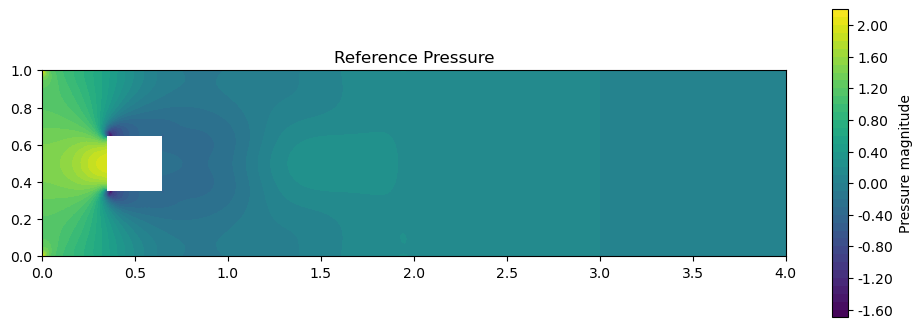

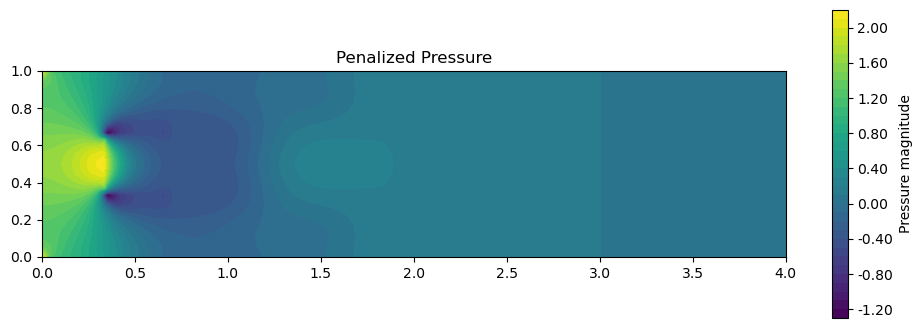

In [85]:
# Plot solution
plt.figure(figsize=(12, 4))
rpp = plot(p1_ref, title="Reference Pressure")
rpb = plt.colorbar(rpp, format="%.2f")
rpb.set_label("Pressure magnitude")

plt.figure(figsize=(12, 4))
ppp = plot(p1_penal, title="Penalized Pressure")
ppb = plt.colorbar(ppp, format="%.2f")
ppb.set_label("Pressure magnitude")

plt.show()

<br>
Plot the reference velocity and penalized velocity at the last time step:

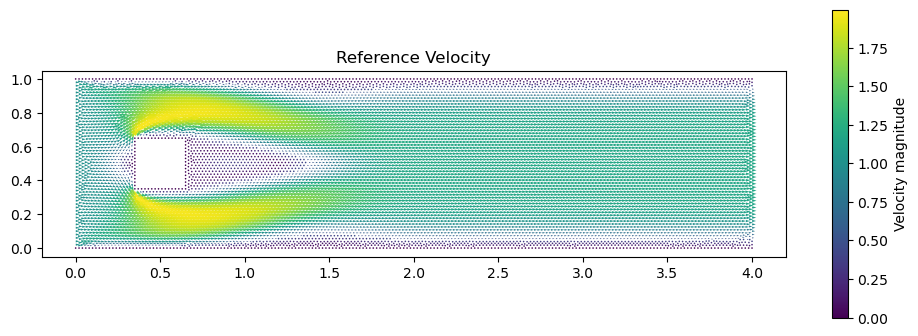

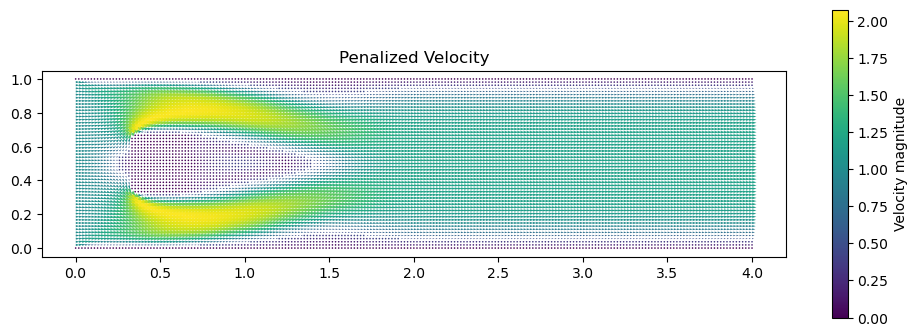

In [82]:
# Plot solution
plt.figure(figsize=(12, 4))
rvp = plot(u1_ref, title="Reference Velocity")
rvb = plt.colorbar(rvp, format="%.2f")
rvb.set_label("Velocity magnitude")

plt.figure(figsize=(12, 4))
pvp = plot(u1_penal, title="Penalized Velocity")
pvb = plt.colorbar(pvp, format="%.2f")
pvb.set_label("Velocity magnitude")

plt.show()

<br>
Plot the reference vorticity and penalized vorticity at the last time step:

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


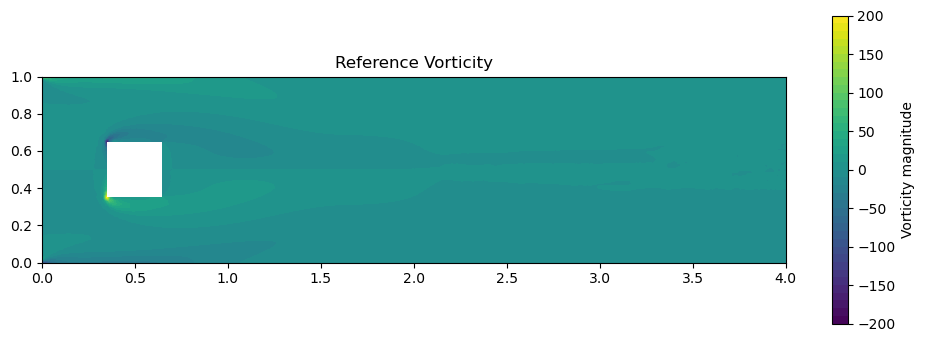

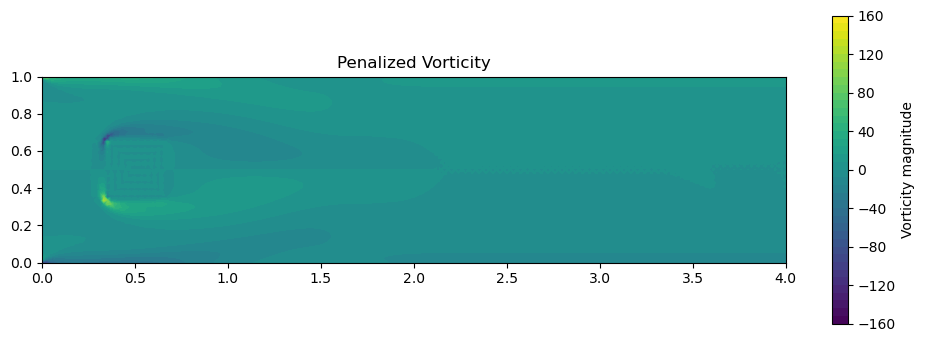

In [108]:

plt.figure(figsize=(12, 4))
rcp = plot(curl(u1_ref), title="Reference Vorticity")
rcb = plt.colorbar(rcp)
rcb.set_label("Vorticity magnitude")

plt.figure(figsize=(12, 4))
pcp = plot(curl(u1_penal), title="Penalized Vorticity")
pcb = plt.colorbar(pcp)
pcb.set_label("Vorticity magnitude")